---<br>
jupyter:<br>
  jupytext:<br>
    formats: py:percent,ipynb<br>
    text_representation:<br>
      extension: .py<br>
      format_name: percent<br>
      format_version: '1.3'<br>
      jupytext_version: 1.14.4<br>
  kernelspec:<br>
    display_name: Python 3 (ipykernel)<br>
    language: python<br>
    name: python3<br>
---

%% [markdown]<br>
# Diffusion Models for Implicit Image Segmentation Ensembles<br>
<br>
This tutorial illustrates how to use MONAI for training a 2D segmentation of images using DDPMs [1].<br>
The same structure can also be used for conditional image generationor image-to-image translation, as proposed in [2,3]
<br>
<br>
[1] - Wolleb et al. "Diffusion Models for Implicit Image Segmentation Ensembles" https://arxiv.org/abs/2112.03145<br>
[2] - Waibel et al. "A Diffusion Model Predicts 3D Shapes from 2D Microscopy Images" https://arxiv.org/abs/2208.14125<br>
[3] - Durrer et al. "Diffusion Models for Contrast Harmonization of Magnetic Resonance Images"
<br>
<br>
<br>
## Setup environment

In [1]:

!python /home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/setup.py install
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn

running install
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing generative.egg-info/PKG-INFO
writing dependency_links to generative.egg-info/dependency_links.txt
writing requirements to generative.egg-info/requires.txt
writing top-level names to generative.egg-info/top_level.txt
reading manifest file 'generative.egg-info/SOURCES.txt'
writing manifest file 'generative.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build/bdist.linux-x86_64/egg
creating buil

%% [markdown]<br>
## Setup imports

%% jupyter={"outputs_hidden": false}<br>
Copyright 2020 MONAI Consortium<br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br>
You may obtain a copy of the License at<br>
    http://www.apache.org/licenses/LICENSE-2.0<br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.

In [2]:
import os
import sys
import time
from typing import Dict

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [29]:
from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import  DiffusionModelUNet
from generative.networks.schedulers.ddpm import DDPMScheduler

In [ ]:
torch.multiprocessing.set_sharing_strategy("file_system")

In [5]:
sys.path.append("/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/")
print("path", sys.path)

path ['/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/tutorials/anomalydetection/segmentation', '/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/tutorials/anomalydetection/segmentation', '/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/tutorials/anomalydetection/segmentation/MONAI', '/home/juliawolleb/anaconda3/envs/experiment/lib/python310.zip', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/lib-dynload', '', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/PyYAML-6.0-py3.10-linux-x86_64.egg', '/home/juliawolleb/PycharmProjects/Python_Tutorials/Calgary_Infants/calgary/HD-BET', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/lpips-0.1.4-py3.10.egg', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/tqdm-4.64.1-py3.10.egg', '/home/juliaw

In [6]:
print_config()

MONAI version: 1.2.dev2304
Numpy version: 1.23.2
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



%% [markdown]<br>
## Setup data directory

%% jupyter={"outputs_hidden": false}

In [9]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = "/home/juliawolleb/PycharmProjects/MONAI/brats"  # path to where the data is stored

%% [markdown]<br>
## Set deterministic training for reproducibility

%% jupyter={"outputs_hidden": false}

In [10]:
set_determinism(42)

%% [markdown] tags=[]<br>
## Setup BRATS Dataset in 2D slices for training<br>
We load the BRATS dataset of the Medical Segmentation Decathlon.
If we set `preprocessing_train=True`, we stack all slices into a tensor and save it as _total_train_slices.pt_.<br>
If we set `preprocessing_train=False`, we load the saved tensor.<br>
The corresponding labels are saved as _total_train_labels.pt._

%% [markdown]<br>
Here we use transforms to augment the training dataset, as usual:<br>
<br>
1. `LoadImaged` loads the hands images from files.<br>
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.<br>
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].<br>
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.<br>
<br>


%%

In [11]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

In [12]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image", "label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(
            keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0).float().squeeze()
        ),
    ]
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


%% jupyter={"outputs_hidden": false}

In [13]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print("len train data", len(train_ds))

len train data 388


In [14]:
def get_batched_2d_axial_slices(data: Dict):
    images_3D = data["image"]
    label_3D= data["label"]
    batched_2d_slices = torch.cat(images_3D.split(1, dim=-1)[10:-10], 0).squeeze(-1)  # we cut the lowest and highest 10 slices, because we are interested in the middle part of the brain.
    slice_label = torch.cat(label_3D.split(1, dim=-1)[10:-10], 0).squeeze(-1)
    return batched_2d_slices, slice_label

In [18]:
preprocessing_train = False
train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

check_data = first(train_loader_3D)
print('check_data', check_data['image'].shape,  check_data['label'].shape)

check_data torch.Size([1, 1, 64, 64, 64]) torch.Size([1, 1, 64, 64, 64])


In [22]:
if preprocessing_train is True:
    train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
    
    print(f'Image shape {train_ds[0]["image"].shape}')
    data_2d_slices = []
    data_label = []
    for i, data in enumerate(train_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices.append(b2d)
        data_label.append(slice_label2d)
    total_train_slices = torch.cat(data_2d_slices, 0)
    total_train_labels = torch.cat(data_slice_label, 0)
    torch.save(total_train_slices, "total_train_slices.pt")
    torch.save(total_train_labels, "total_train_labels.pt")
else:
    total_train_slices = torch.load("total_train_slices.pt")
    total_train_labels = torch.load("total_train_labels.pt")
    print("total slices", total_train_slices.shape)
    print("total lbaels", total_train_labels.shape)

total slices torch.Size([17072, 1, 64, 64])
total lbaels torch.Size([17072, 1, 64, 64])


%% [markdown] tags=[]<br>
## Setup BRATS Dataset in 2D slices for validation<br>
As baseline, we use the load_2d_brats.ipynb written by Pedro in issue 150.<br>
If we set `preprocessing_val=True`, we stack all slices into a tensor and save it as _total_val_slices.pt_.<br>
If we set `preprocessing_val=False`, we load the saved tensor.<br>
The corresponding labels are saved as _total_val_labels.pt_.

%%

In [23]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)

In [24]:
preprocessing_val = False
if preprocessing_val is True:
    val_loader_3D = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)
    print(f'Image shape {val_ds[0]["image"].shape}')
    print("len val data", len(val_ds))
    data_2d_slices_val = []
    data_slice_label_val = []
    for i, data in enumerate(val_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices_val.append(b2d)
        data_slice_label_val.append(slice_label2d)
    total_val_slices = torch.cat(data_2d_slices_val, 0)
    total_val_labels = torch.cat(data_slice_label_val, 0)
    torch.save(total_val_slices, "total_val_slices.pt")
    torch.save(total_val_labels, "total_val_labels.pt")
    
else:
    total_val_slices = torch.load("total_val_slices.pt")
    total_val_labels = torch.load("total_val_labels.pt")
    print("total slices", total_val_slices.shape)
    print("total lbaels", total_val_labels.shape)

total slices torch.Size([4224, 1, 64, 64])
total lbaels torch.Size([4224, 1, 64, 64])


%% [markdown]<br>
### Define network, scheduler, optimizer, and inferer<br>
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using<br>
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms<br>
in the 3rd level (`num_head_channels=64`).<br>


%% jupyter={"outputs_hidden": false}

In [25]:
device = torch.device("cuda")

In [26]:
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
    #  cross_attention_dim=1,
)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

In [30]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)

In [31]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

In [32]:
inferer = DiffusionInferer(scheduler)

%% [markdown] tags=[]<br>
### Model training of the Diffusion Model<br>
If we set `train_diffusionmodel=True`, we are training our diffusion model for 100 epochs, and save the model as _diffusion_model.pt_.<br>
If we set `train_diffusionmodel=False`, we load a pretrained model.

%% jupyter={"outputs_hidden": false}

In [39]:
n_epochs = 100
batch_size = 32
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []
train_diffusionmodel = False

Epoch 0: : 534it [01:40,  5.34it/s, loss=0.00782]                                           
4224it [01:28, 47.71it/s]
Epoch 1: : 534it [01:46,  5.01it/s, loss=0.00693]                                           
4224it [01:27, 48.24it/s]
Epoch 2: : 534it [01:47,  4.96it/s, loss=0.00641]                                           
4224it [01:28, 47.58it/s]
Epoch 3: : 534it [01:47,  4.95it/s, loss=0.00602]                                           
4224it [01:30, 46.61it/s]
Epoch 4: : 534it [01:48,  4.93it/s, loss=0.00577]                                           
4224it [01:28, 47.78it/s]
Epoch 5: : 534it [01:47,  4.96it/s, loss=0.00552]                                           
4224it [01:27, 48.48it/s]
Epoch 6: : 534it [01:47,  4.97it/s, loss=0.00518]                                           
4224it [01:27, 48.31it/s]
Epoch 7: : 534it [01:47,  4.95it/s, loss=0.00513]                                           
4224it [01:27, 48.49it/s]
Epoch 8: : 534it [01:47,  4.95it/s, loss=0.0049]

train diffusion completed, total time: 39109.052657842636.


ValueError: x and y must have same first dimension, but have shapes (200,) and (202,)

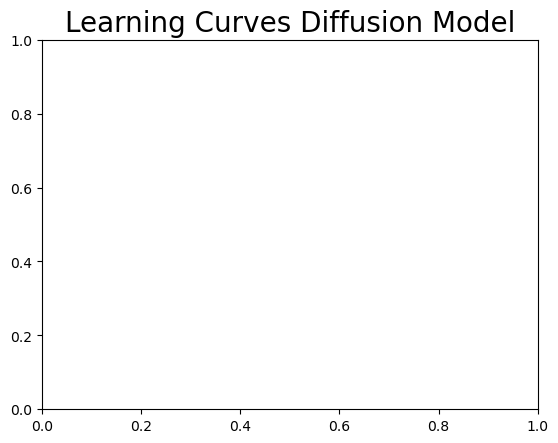

In [42]:
if train_diffusionmodel is False:
    model.load_state_dict(torch.load("seg_model.pt", map_location={"cuda:0": "cpu"}))
else:
    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        indexes = list(torch.randperm(total_train_slices.shape[0]))  # shuffle training data new
        data_train = total_train_slices[indexes]  # shuffle the training data
        labels_train = total_train_labels[indexes]
        subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))
        subset_2D_val = zip(total_val_slices.split(1), total_val_labels.split(1))  #
        progress_bar = tqdm(enumerate(subset_2D), total=len(indexes) / batch_size)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, (a, b) in progress_bar:
            images = a.to(device)
            seg = b.to(device)  #this is the ground truth segmentation
            optimizer.zero_grad(set_to_none=True)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)  # pick a random time step t
            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(seg).to(device)
                noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)  #we only add noise to the segmentation mask
                combined=torch.cat((images,noisy_seg), dim=1)                               #we concatenate the brain MR image with the noisy segmenatation mask, to condition the generation process
                prediction = model(x=combined, timesteps=timesteps)
                # Get model prediction 
                loss = F.mse_loss(prediction.float(), noise.float())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            progress_bar.set_postfix(
                {
                    "loss": epoch_loss / (step + 1),
                }
            )
        epoch_loss_list.append(epoch_loss / (step + 1))
        if (epoch) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar_val = tqdm(enumerate(subset_2D_val))
            progress_bar.set_description(f"Epoch {epoch}")
            for step, (a, b) in progress_bar_val:
                images = a.to(device)
                seg = b.to(device)
                timesteps = torch.randint(0, 1000, (len(images),)).to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(seg).to(device)
                        noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)
                        combined=torch.cat((images,noisy_seg), dim=1)
                        prediction = model(x=combined, timesteps=timesteps)
                        val_loss = F.mse_loss(prediction.float(), noise.float())
                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix(
                    {
                        "val_loss": val_epoch_loss / (step + 1),
                    }
                )
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))
    total_time = time.time() - total_start
   # torch.save(model.state_dict(), "./seg_model.pt")  # save the trained model
    print(f"train diffusion completed, total time: {total_time}.")
    plt.style.use("seaborn-bright")
    plt.title("Learning Curves Diffusion Model", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

%% [markdown]<br>
### Sampling of a new segmentation Mask for an input image of the validation set<br>



%% jupyter={"outputs_hidden": false}

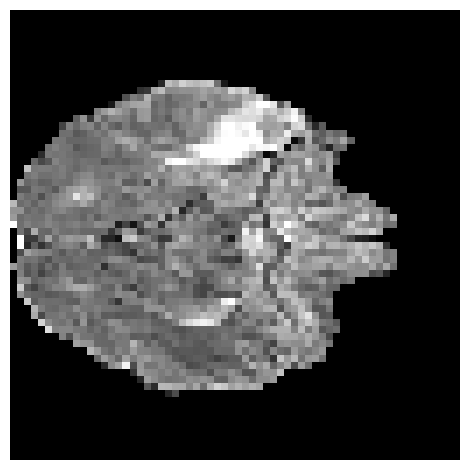

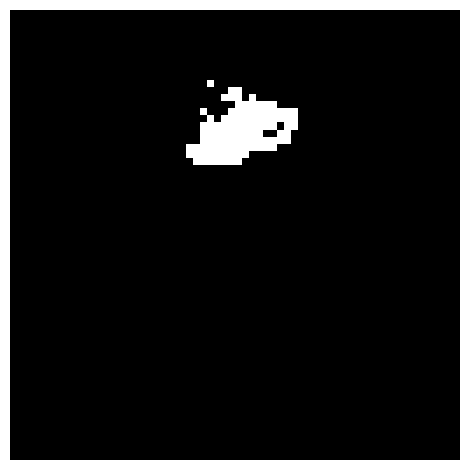

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

In [53]:
inputimg = total_val_slices[100][0,...]  # Pick an input slice of the validation set to be segmented  
inputlabel= total_val_labels[100][0,...]     # Check out the ground truth label mask%% [markdown]

plt.figure("input"+str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure("input"+str(inputlabel))
plt.imshow(inputlabel, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


model.eval()



In [55]:
input_img = inputimg[None, None, ...].to(device)
noise = torch.randn_like(input_img).to(device)   #for the segmentation mask, we start from random noise
current_img=noise
combined=torch.cat((input_img,noise), dim=1)
scheduler.set_timesteps(num_inference_steps=1000)

 10%|█████▏                                               | 97/1000 [00:02<00:18, 48.98it/s]

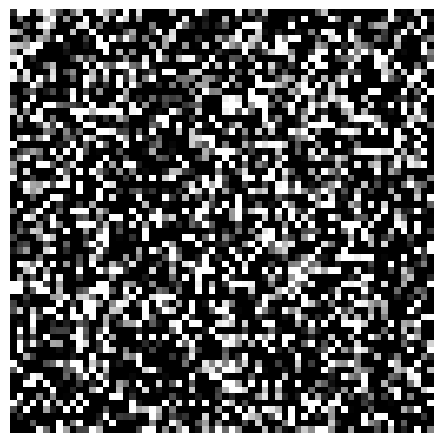

 20%|██████████▏                                         | 197/1000 [00:04<00:15, 50.26it/s]

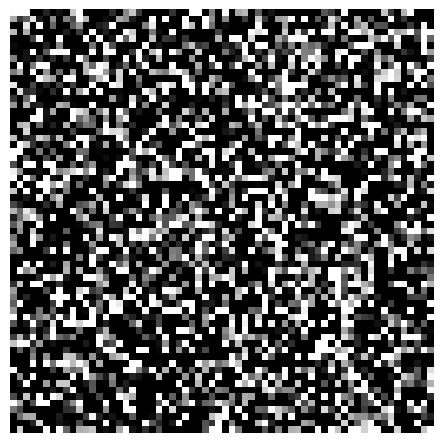

 30%|███████████████▌                                    | 299/1000 [00:06<00:13, 50.97it/s]

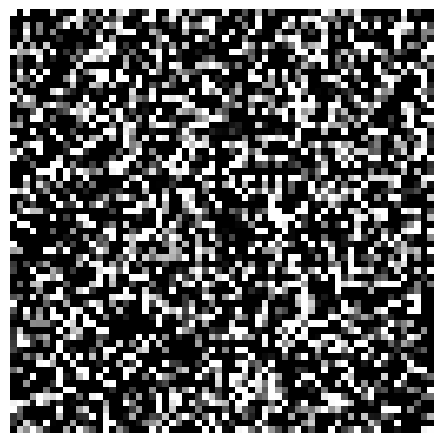

 40%|████████████████████▌                               | 395/1000 [00:08<00:11, 50.92it/s]

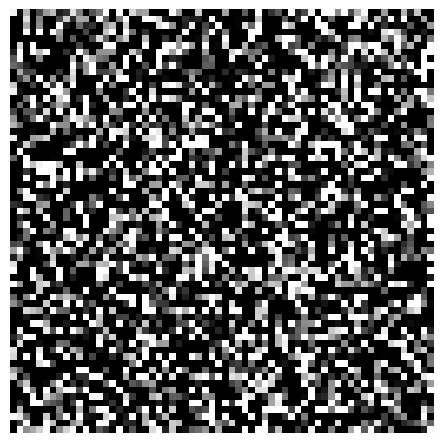

 50%|█████████████████████████▊                          | 496/1000 [00:10<00:09, 50.74it/s]

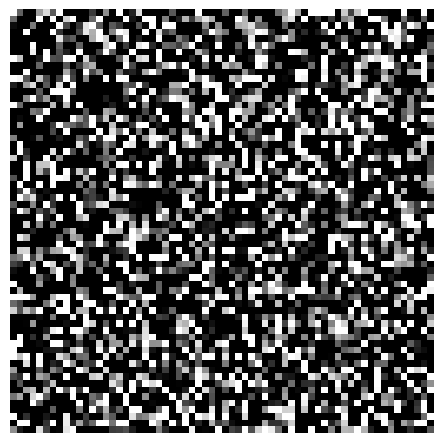

 60%|██████████████████████████████▉                     | 596/1000 [00:12<00:07, 50.81it/s]

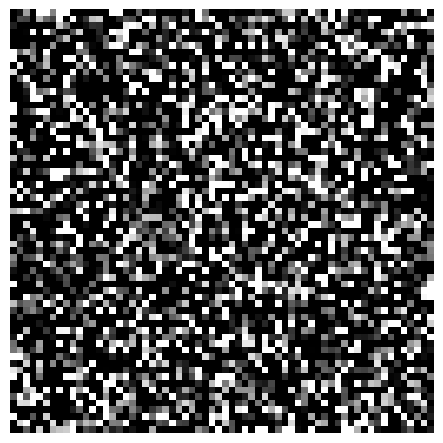

 70%|████████████████████████████████████▎               | 698/1000 [00:14<00:05, 50.48it/s]

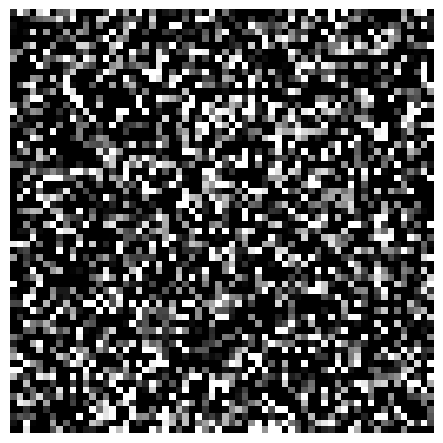

 79%|█████████████████████████████████████████▎          | 794/1000 [00:16<00:04, 50.81it/s]

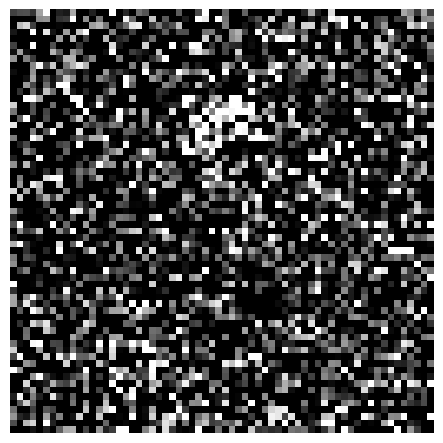

 89%|██████████████████████████████████████████████▍     | 894/1000 [00:18<00:02, 50.83it/s]

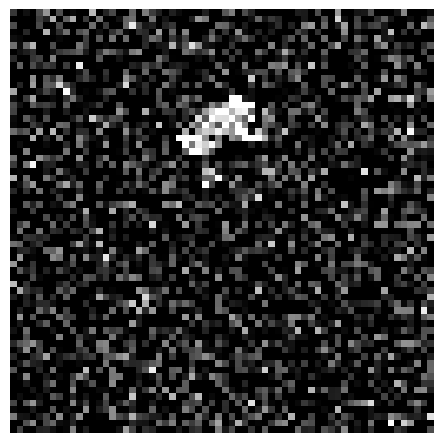

 99%|███████████████████████████████████████████████████▋| 994/1000 [00:20<00:00, 50.56it/s]

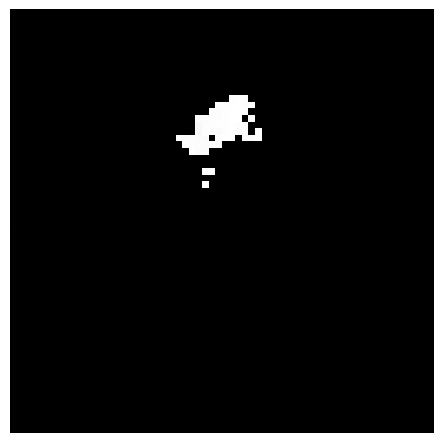

100%|███████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.39it/s]


In [64]:
scheduler.set_timesteps(num_inference_steps=1000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:  # go through the noising process
    with autocast(enabled=False):
        with torch.no_grad():
            model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
            current_img, _ = scheduler.step(model_output, t, current_img)   
            if t%100==0:
                plt.style.use("default")
                plt.imshow(current_img[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.tight_layout()
                plt.axis("off")
                plt.show()
            combined=torch.cat((input_img,current_img), dim=1)   #in every step during the denoising process, the brain MR image is concatenated to add anatomical information




In [ ]:
%% [markdown]<br>
### Segmentation prediction
The predicted segmentation mask is obtained from the output of the diffusion model by thresholding



inptulabel torch.Size([64, 64])


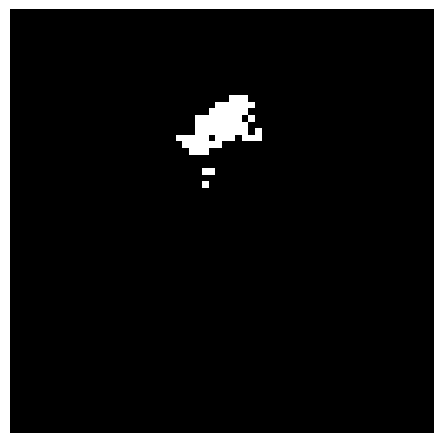

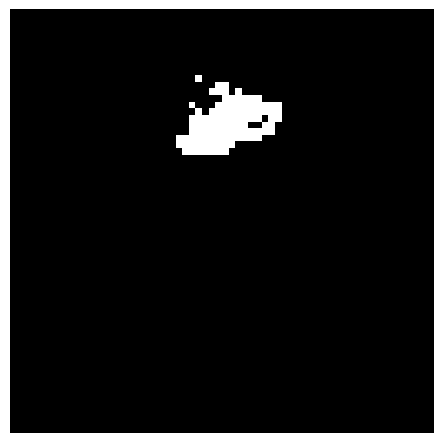

In [72]:
print('inptulabel', inputlabel.shape)

prediction=torch.zeros(current_img.shape)  #this is the output of the diffusion model after T=1000 denoising steps.
prediction[current_img>0.5]=1   #a binary mask is obtained via thresholding

plt.style.use("default")
plt.imshow(prediction[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(inputlabel.cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()



%% [markdown]<br>
## Segmentation Performance<br>
We compute the Dice score to evaluate the segmentation performance.

In [82]:
def dice_coeff(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() / im_sum)


In [83]:
score=dice_coeff(prediction[0, 0].cpu(), inputlabel.cpu())
print('score', score)

score 0.7272727272727273


%% [markdown]<br>
# Segmentation Scores<br>
We compute the Dice scores over the validation set (this takes a while...)

%%

In [95]:
total_dice=0; number=0
subset_2D_val = zip(total_val_slices.split(1), total_val_labels.split(1))  #

for step, (a, b) in enumerate(subset_2D_val):
    images = a.to(device)
    seg = b.to(device)
  
    if seg.sum()==0:
        continue
    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    progress_bar.set_description(f"subject {number}")
    noise = torch.randn_like(seg).to(device)
    combined=torch.cat((images,noise), dim=1)

    for t in progress_bar:  # go through the denoising process
        with autocast(enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(model_output, t, current_img)
                   
                combined=torch.cat((images,current_img), dim=1)
    
    prediction=torch.zeros(current_img.shape)
    prediction[current_img>0.5]=1
    score=dice_coeff(prediction[0, 0].cpu(), seg[0,0].cpu())

    print('number', number, 'score', score)
    number+=1
    total_dice+=score

print('mean dice', total_dice/number)

subject 0: 100%|████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.30it/s]


number 0 score 0.0


subject 1: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.30it/s]


number 1 score 0.0


subject 2: 100%|████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.16it/s]


number 2 score 0.7933884297520661


subject 3: 100%|████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.15it/s]


number 3 score 0.8950276243093923


subject 4: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.78it/s]


number 4 score 0.8858447488584474


subject 5: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 5 score 0.8898678414096917


subject 6: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.65it/s]


number 6 score 0.8852459016393442


subject 7: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.85it/s]


number 7 score 0.8461538461538461


subject 8: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.92it/s]


number 8 score 0.9163636363636364


subject 9: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.18it/s]


number 9 score 0.9309090909090909


subject 10: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.84it/s]


number 10 score 0.927536231884058


subject 11: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.27it/s]


number 11 score 0.9144981412639405


subject 12: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.64it/s]


number 12 score 0.9411764705882353


subject 13: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.73it/s]


number 13 score 0.8968253968253969


subject 14: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.11it/s]


number 14 score 0.897119341563786


subject 15: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.80it/s]


number 15 score 0.9210526315789473


subject 16: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.13it/s]


number 16 score 0.8729281767955801


subject 17: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.27it/s]


number 17 score 0.9014084507042254


subject 18: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.54it/s]


number 18 score 0.7663551401869159


subject 19: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.52it/s]


number 19 score 0.0


subject 20: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.02it/s]


number 20 score 0.0


subject 21: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.61it/s]


number 21 score 0.0


subject 22: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.37it/s]


number 22 score 0.0


subject 23: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.17it/s]


number 23 score 0.0


subject 24: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.70it/s]


number 24 score 0.029411764705882353


subject 25: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.61it/s]


number 25 score 0.46846846846846846


subject 26: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.00it/s]


number 26 score 0.5608465608465608


subject 27: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.03it/s]


number 27 score 0.6604651162790698


subject 28: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.98it/s]


number 28 score 0.6274509803921569


subject 29: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.03it/s]


number 29 score 0.6369047619047619


subject 30: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.02it/s]


number 30 score 0.6798029556650246


subject 31: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.87it/s]


number 31 score 0.7116564417177914


subject 32: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.97it/s]


number 32 score 0.8163934426229508


subject 33: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.60it/s]


number 33 score 0.8459302325581395


subject 34: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.99it/s]


number 34 score 0.9181208053691275


subject 35: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.71it/s]


number 35 score 0.9299191374663073


subject 36: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.00it/s]


number 36 score 0.9137466307277629


subject 37: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.93it/s]


number 37 score 0.9197860962566845


subject 38: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.66it/s]


number 38 score 0.8990578734858681


subject 39: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.01it/s]


number 39 score 0.8772919605077574


subject 40: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.20it/s]


number 40 score 0.835820895522388


subject 41: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.93it/s]


number 41 score 0.8424242424242424


subject 42: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.95it/s]


number 42 score 0.8273615635179153


subject 43: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.02it/s]


number 43 score 0.7964912280701755


subject 44: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.77it/s]


number 44 score 0.8542024013722127


subject 45: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.06it/s]


number 45 score 0.8587155963302753


subject 46: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.55it/s]


number 46 score 0.8313725490196079


subject 47: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.98it/s]


number 47 score 0.8619246861924686


subject 48: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.96it/s]


number 48 score 0.8416075650118203


subject 49: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.03it/s]


number 49 score 0.8372093023255814


subject 50: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.02it/s]


number 50 score 0.8414634146341463


subject 51: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.00it/s]


number 51 score 0.896551724137931


subject 52: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 52 score 0.925764192139738


subject 53: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


number 53 score 0.918918918918919


subject 54: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.18it/s]


number 54 score 0.7933884297520661


subject 55: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.99it/s]


number 55 score 0.7164179104477612


subject 56: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.89it/s]


number 56 score 0.0


subject 57: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.93it/s]


number 57 score 0.0


subject 58: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.68it/s]


number 58 score 0.0


subject 59: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.92it/s]


number 59 score 0.0


subject 60: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.74it/s]


number 60 score 0.0


subject 61: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


number 61 score 0.0


subject 62: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.99it/s]


number 62 score 0.0


subject 63: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.82it/s]


number 63 score 0.0


subject 64: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.82it/s]


number 64 score 0.0


subject 65: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


number 65 score 0.0


subject 66: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.86it/s]


number 66 score 0.43373493975903615


subject 67: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 67 score 0.48854961832061067


subject 68: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.93it/s]


number 68 score 0.7085714285714285


subject 69: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.65it/s]


number 69 score 0.7692307692307693


subject 70: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 70 score 0.74235807860262


subject 71: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.73it/s]


number 71 score 0.8592592592592593


subject 72: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.94it/s]


number 72 score 0.9245901639344263


subject 73: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.85it/s]


number 73 score 0.8761904761904762


subject 74: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.67it/s]


number 74 score 0.8754208754208754


subject 75: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.92it/s]


number 75 score 0.8745247148288974


subject 76: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.97it/s]


number 76 score 0.8796680497925311


subject 77: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.10it/s]


number 77 score 0.8042328042328042


subject 78: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 78 score 0.7785234899328859


subject 79: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.87it/s]


number 79 score 0.7407407407407407


subject 80: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.98it/s]


number 80 score 0.5


subject 81: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.73it/s]


number 81 score 0.0


subject 82: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 82 score 0.0


subject 83: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.52it/s]


number 83 score 0.0


subject 84: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.96it/s]


number 84 score 0.0


subject 85: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


number 85 score 0.0


subject 86: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.76it/s]


number 86 score 0.0


subject 87: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.89it/s]


number 87 score 0.0


subject 88: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.84it/s]


number 88 score 0.0


subject 89: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.86it/s]


number 89 score 0.0


subject 90: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.64it/s]


number 90 score 0.0


subject 91: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.44it/s]


number 91 score 0.0


subject 92: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.38it/s]


number 92 score 0.0


subject 93: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.76it/s]


number 93 score 0.0


subject 94: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.87it/s]


number 94 score 0.0


subject 95: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.83it/s]


number 95 score 0.0


subject 96: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.83it/s]


number 96 score 0.0


subject 97: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.90it/s]


number 97 score 0.4


subject 98: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.94it/s]


number 98 score 0.5132743362831859


subject 99: 100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.74it/s]


number 99 score 0.6960352422907489


subject 100: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.89it/s]


number 100 score 0.782608695652174


subject 101: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 101 score 0.9204819277108434


subject 102: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.82it/s]


number 102 score 0.96


subject 103: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.49it/s]


number 103 score 0.9230769230769231


subject 104: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.77it/s]


number 104 score 0.9445438282647585


subject 105: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.80it/s]


number 105 score 0.9562289562289562


subject 106: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.48it/s]


number 106 score 0.9631901840490797


subject 107: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.08it/s]


number 107 score 0.9596412556053812


subject 108: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 108 score 0.9522431259044862


subject 109: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 109 score 0.9706293706293706


subject 110: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 110 score 0.9370424597364568


subject 111: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.82it/s]


number 111 score 0.948301329394387


subject 112: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.68it/s]


number 112 score 0.9624060150375939


subject 113: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.70it/s]


number 113 score 0.9585253456221198


subject 114: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 114 score 0.968944099378882


subject 115: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.76it/s]


number 115 score 0.9508196721311475


subject 116: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.70it/s]


number 116 score 0.9651741293532339


subject 117: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 117 score 0.9565217391304348


subject 118: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.65it/s]


number 118 score 0.9558823529411765


subject 119: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 119 score 0.9168356997971603


subject 120: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.85it/s]


number 120 score 0.9006622516556292


subject 121: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.78it/s]


number 121 score 0.89


subject 122: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.62it/s]


number 122 score 0.9361702127659575


subject 123: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


number 123 score 0.8834355828220859


subject 124: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.92it/s]


number 124 score 0.8333333333333334


subject 125: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.40it/s]


number 125 score 0.8133704735376045


subject 126: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.89it/s]


number 126 score 0.8181818181818182


subject 127: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


number 127 score 0.8584905660377359


subject 128: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.72it/s]


number 128 score 0.8981288981288982


subject 129: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.53it/s]


number 129 score 0.8905380333951762


subject 130: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.55it/s]


number 130 score 0.900163666121113


subject 131: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.87it/s]


number 131 score 0.9166666666666666


subject 132: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.94it/s]


number 132 score 0.9268929503916449


subject 133: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.13it/s]


number 133 score 0.9451073985680191


subject 134: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]


number 134 score 0.9539170506912442


subject 135: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.30it/s]


number 135 score 0.9409090909090909


subject 136: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.23it/s]


number 136 score 0.9400218102508179


subject 137: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.24it/s]


number 137 score 0.9188619599578504


subject 138: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.22it/s]


number 138 score 0.9289617486338798


subject 139: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.30it/s]


number 139 score 0.9297658862876255


subject 140: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.21it/s]


number 140 score 0.9347079037800687


subject 141: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.30it/s]


number 141 score 0.9214780600461894


subject 142: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.29it/s]


number 142 score 0.9239904988123515


subject 143: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.34it/s]


number 143 score 0.9214026602176542


subject 144: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.25it/s]


number 144 score 0.8634361233480177


subject 145: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]


number 145 score 0.8622540250447227


subject 146: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.04it/s]


number 146 score 0.8456659619450317


subject 147: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.27it/s]


number 147 score 0.8936170212765957


subject 148: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]


number 148 score 0.8494208494208494


subject 149: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.32it/s]


number 149 score 0.8899521531100478


subject 150: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.24it/s]


number 150 score 0.8982035928143712


subject 151: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.30it/s]


number 151 score 0.8857142857142857


subject 152: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.25it/s]


number 152 score 0.8623853211009175


subject 153: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.18it/s]


number 153 score 0.7941176470588235


subject 154: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]


number 154 score 0.5806451612903226


subject 155: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.14it/s]


number 155 score 0.0


subject 156: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.81it/s]


number 156 score 0.0


subject 157: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.29it/s]


number 157 score 0.0


subject 158: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.28it/s]


number 158 score 0.45714285714285713


subject 159: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.22it/s]


number 159 score 0.36936936936936937


subject 160: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.16it/s]


number 160 score 0.8603773584905661


subject 161: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.29it/s]


number 161 score 0.9147286821705426


subject 162: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.24it/s]


number 162 score 0.9365482233502538


subject 163: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.20it/s]


number 163 score 0.9571263035921205


subject 164: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]


number 164 score 0.9552572706935123


subject 165: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.27it/s]


number 165 score 0.9570680628272251


subject 166: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.19it/s]


number 166 score 0.9617271835132483


subject 167: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.33it/s]


number 167 score 0.9518413597733711


subject 168: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.35it/s]


number 168 score 0.9550045913682277


subject 169: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.28it/s]


number 169 score 0.9666080843585237


subject 170: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.18it/s]


number 170 score 0.9585492227979274


subject 171: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.26it/s]


number 171 score 0.9554794520547946


subject 172: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.22it/s]


number 172 score 0.9590443686006825


subject 173: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.27it/s]


number 173 score 0.9483648881239243


subject 174: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.22it/s]


number 174 score 0.9366869037294016


subject 175: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.21it/s]


number 175 score 0.936663693131133


subject 176: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.23it/s]


number 176 score 0.9420560747663551


subject 177: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.22it/s]


number 177 score 0.9486166007905138


subject 178: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 57.24it/s]


number 178 score 0.9567010309278351


subject 179: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.53it/s]


number 179 score 0.9644444444444444


subject 180: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 53.57it/s]


number 180 score 0.9484777517564403


subject 181: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.09it/s]


number 181 score 0.9534313725490197


subject 182: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.43it/s]


number 182 score 0.940554821664465


subject 183: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.85it/s]


number 183 score 0.9382352941176471


subject 184: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.37it/s]


number 184 score 0.9405940594059405


subject 185: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.05it/s]


number 185 score 0.945179584120983


subject 186: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.00it/s]


number 186 score 0.9369369369369369


subject 187: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.22it/s]


number 187 score 0.9393939393939394


subject 188: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.03it/s]


number 188 score 0.969187675070028


subject 189: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.56it/s]


number 189 score 0.9685534591194969


subject 190: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.26it/s]


number 190 score 0.0


subject 191: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.18it/s]


number 191 score 0.0


subject 192: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.44it/s]


number 192 score 0.0


subject 193: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.39it/s]


number 193 score 0.0


subject 194: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.96it/s]


number 194 score 0.0


subject 195: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.79it/s]


number 195 score 0.0


subject 196: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


number 196 score 0.11267605633802817


subject 197: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.82it/s]


number 197 score 0.18518518518518517


subject 198: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.01it/s]


number 198 score 0.07058823529411765


subject 199: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.75it/s]


number 199 score 0.0


subject 200: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.80it/s]


number 200 score 0.0


subject 201: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.39it/s]


number 201 score 0.5238095238095238


subject 202: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


number 202 score 0.2948717948717949


subject 203: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.36it/s]


number 203 score 0.5123152709359606


subject 204: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.73it/s]


number 204 score 0.6159695817490495


subject 205: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.88it/s]


number 205 score 0.6710963455149501


subject 206: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.10it/s]


number 206 score 0.643312101910828


subject 207: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.23it/s]


number 207 score 0.5774647887323944


subject 208: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.51it/s]


number 208 score 0.6787003610108303


subject 209: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.24it/s]


number 209 score 0.5688888888888889


subject 210: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.87it/s]


number 210 score 0.0


subject 211: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.57it/s]


number 211 score 0.0


subject 212: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.50it/s]


number 212 score 0.0


subject 213: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.25it/s]


number 213 score 0.0


subject 214: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.83it/s]


number 214 score 0.0


subject 215: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.07it/s]


number 215 score 0.0


subject 216: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.20it/s]


number 216 score 0.0


subject 217: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.93it/s]


number 217 score 0.01834862385321101


subject 218: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.55it/s]


number 218 score 0.0


subject 219: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.45it/s]


number 219 score 0.14583333333333334


subject 220: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.68it/s]


number 220 score 0.0


subject 221: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.47it/s]


number 221 score 0.0


subject 222: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.46it/s]


number 222 score 0.2


subject 223: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.54it/s]


number 223 score 0.0


subject 224: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.83it/s]


number 224 score 0.0


subject 225: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.74it/s]


number 225 score 0.0


subject 226: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.20it/s]


number 226 score 0.8727272727272727


subject 227: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.10it/s]


number 227 score 0.9473684210526315


subject 228: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.50it/s]


number 228 score 0.919431279620853


subject 229: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.28it/s]


number 229 score 0.966542750929368


subject 230: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.87it/s]


number 230 score 0.9403508771929825


subject 231: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.38it/s]


number 231 score 0.9411764705882353


subject 232: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.66it/s]


number 232 score 0.9294117647058824


subject 233: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.12it/s]


number 233 score 0.8994413407821229


subject 234: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.20it/s]


number 234 score 0.9183673469387755


subject 235: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.96it/s]


number 235 score 0.8928571428571429


subject 236: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.35it/s]


number 236 score 0.9121951219512195


subject 237: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.90it/s]


number 237 score 0.9056603773584906


subject 238: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.95it/s]


number 238 score 0.8958837772397095


subject 239: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.54it/s]


number 239 score 0.8985507246376812


subject 240: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.71it/s]


number 240 score 0.8390501319261213


subject 241: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.90it/s]


number 241 score 0.8630490956072352


subject 242: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.39it/s]


number 242 score 0.8856304985337243


subject 243: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.78it/s]


number 243 score 0.8447653429602888


subject 244: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.23it/s]


number 244 score 0.3695652173913043


subject 245: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.64it/s]


number 245 score 0.0


subject 246: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.08it/s]


number 246 score 0.0


subject 247: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.09it/s]


number 247 score 0.0


subject 248: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


number 248 score 0.0


subject 249: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.23it/s]


number 249 score 0.0


subject 250: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.46it/s]


number 250 score 0.0


subject 251: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.23it/s]


number 251 score 0.0


subject 252: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.03it/s]


number 252 score 0.0


subject 253: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.39it/s]


number 253 score 0.6060606060606061


subject 254: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.97it/s]


number 254 score 0.6194690265486725


subject 255: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.85it/s]


number 255 score 0.7142857142857143


subject 256: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.25it/s]


number 256 score 0.8533333333333334


subject 257: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.35it/s]


number 257 score 0.717948717948718


subject 258: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.68it/s]


number 258 score 0.8055555555555556


subject 259: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.41it/s]


number 259 score 0.8181818181818182


subject 260: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.83it/s]


number 260 score 0.7619047619047619


subject 261: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.96it/s]


number 261 score 0.7897435897435897


subject 262: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.65it/s]


number 262 score 0.8626198083067093


subject 263: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.10it/s]


number 263 score 0.7490636704119851


subject 264: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.54it/s]


number 264 score 0.8194233687405159


subject 265: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.82it/s]


number 265 score 0.8326530612244898


subject 266: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.96it/s]


number 266 score 0.827683615819209


subject 267: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.90it/s]


number 267 score 0.8485675306957708


subject 268: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.09it/s]


number 268 score 0.8195266272189349


subject 269: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.57it/s]


number 269 score 0.7801857585139319


subject 270: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.96it/s]


number 270 score 0.766295707472178


subject 271: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.66it/s]


number 271 score 0.8460431654676259


subject 272: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.47it/s]


number 272 score 0.6690017513134852


subject 273: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.18it/s]


number 273 score 0.6502636203866432


subject 274: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.89it/s]


number 274 score 0.6974169741697417


subject 275: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.38it/s]


number 275 score 0.7823008849557522


subject 276: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.58it/s]


number 276 score 0.8888888888888888


subject 277: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.04it/s]


number 277 score 0.9050086355785838


subject 278: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.31it/s]


number 278 score 0.8881239242685026


subject 279: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.77it/s]


number 279 score 0.8918918918918919


subject 280: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.16it/s]


number 280 score 0.8966942148760331


subject 281: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.30it/s]


number 281 score 0.9045454545454545


subject 282: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.30it/s]


number 282 score 0.9238329238329238


subject 283: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.05it/s]


number 283 score 0.9396325459317585


subject 284: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.13it/s]


number 284 score 0.9258160237388724


subject 285: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.54it/s]


number 285 score 0.8705035971223022


subject 286: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.12it/s]


number 286 score 0.8125


subject 287: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.62it/s]


number 287 score 0.6086956521739131


subject 288: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.63it/s]


number 288 score 0.7936507936507936


subject 289: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.76it/s]


number 289 score 0.8235294117647058


subject 290: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.87it/s]


number 290 score 0.8187134502923976


subject 291: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.16it/s]


number 291 score 0.9172932330827067


subject 292: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 56.06it/s]


number 292 score 0.9067524115755627


subject 293: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.17it/s]


number 293 score 0.8787878787878788


subject 294: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.52it/s]


number 294 score 0.8752556237218814


subject 295: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.84it/s]


number 295 score 0.8722627737226277


subject 296: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.65it/s]


number 296 score 0.9146537842190016


subject 297: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


number 297 score 0.9251908396946565


subject 298: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.61it/s]


number 298 score 0.9380530973451328


subject 299: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.16it/s]


number 299 score 0.96045197740113


subject 300: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.83it/s]


number 300 score 0.9346590909090909


subject 301: 100%|██████████████████████████████████████| 1000/1000 [00:17<00:00, 55.59it/s]


number 301 score 0.9481065918653576


subject 302: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.50it/s]


number 302 score 0.9488243430152143


subject 303: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 55.49it/s]


number 303 score 0.9368863955119214


subject 304: 100%|██████████████████████████████████████| 1000/1000 [00:18<00:00, 54.62it/s]


number 304 score 0.9298245614035088


subject 305:  39%|███████████████▏                       | 388/1000 [00:07<00:11, 53.23it/s]


KeyboardInterrupt: 

In [96]:
print('mean dice', total_dice/number)


mean dice 0.6486319880510938
